In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cuda


# Customized Dataset

In [5]:
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)

In [5]:
# class RetinopathyDataset_original(Dataset):
#     def __init__(self, root, mode):
#         self.root = root
#         self.mode = mode
#         self.img_names, self.labels = getData(self.mode)
#         self.length = len(self.img_names)
#         self.transformations = transforms.ToTensor()
#         print("> Found %d images..." % (self.length))
#     def __len__(self):
#         return self.length
#     def __getitem__(self, index):
#         img_name = os.path.join(self.root, self.img_names[index] + '.jpeg')
#         img = Image.open(img_name)
#         img = self.transformations(img)
#         label = self.labels[index]
#         return img, label

In [5]:
batch_size18 = 32 # GPU maximum memory for my laptop

In [7]:
# test_dataset = RetinopathyDataset_original('D:/DL_lab3_data', 'test')
# test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [8]:
# a = iter(train_dataloader)
# b = next(a)
# print(b[0].shape)
# print(b[1].shape)

In [9]:
# compute mean, std for training or testing dataloader
# def get_stat(dataloader):
#     mean, std = 0.0, 0.0
#     for imgs, _ in dataloader:
#         imgs = imgs.view(imgs.size(0), imgs.size(1), -1)
#         mean += imgs.mean(2).sum(0)
#         std += imgs.std(2).sum(0)
#     mean /= len(dataloader.dataset)
#     std /= len(dataloader.dataset)
#     return mean, std

In [10]:
# mean, std = get_stat(train_dataloader)

In [6]:
# torch.save(mean, os.path.join("C:\\Users\\GL75\\OneDrive\\桌面\\深度學習\\Lab3", 'train_mean.pt'))
# torch.save(std, os.path.join("C:\\Users\\GL75\\OneDrive\\桌面\\深度學習\\Lab3", 'train_std.pt'))
mean = torch.load(os.path.join("C:\\Users\\GL75\\OneDrive\\桌面\\深度學習\\Lab3", 'train_mean.pt'))
std = torch.load(os.path.join("C:\\Users\\GL75\\OneDrive\\桌面\\深度學習\\Lab3", 'train_std.pt'))

In [7]:
'''for training data'''
print(mean) # tensor([0.3749, 0.2602, 0.1857])
print(std) # tensor([0.2526, 0.1780, 0.1291])

tensor([0.3749, 0.2602, 0.1857])
tensor([0.2526, 0.1780, 0.1291])


In [8]:
class RetinopathyDataset(Dataset):
    def __init__(self, root, mode, mean, std):
        self.root = root
        self.mode = mode
        self.img_names, self.labels = getData(self.mode)
        self.length = len(self.img_names)
        self.transformations = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        print("> Found %d images..." % (self.length))
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        img_name = os.path.join(self.root, self.img_names[index] + '.jpeg')
        img = Image.open(img_name)
        img = self.transformations(img)
        label = self.labels[index]
        return img, label

# Models

In [9]:
class ResNet18(nn.Module):
    def __init__(self, num_classes = 5, pretrained = True):
        super().__init__()
        self.model = models.resnet18(pretrained = pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.require_grads = False
        num_of_fc_input_neurons = self.model.fc.in_features # 512
        self.model.fc = nn.Linear(num_of_fc_input_neurons, num_classes)
    def forward(self, X):
        outputs = self.model(X)
        return outputs

In [10]:
class ResNet50(nn.Module):
    def __init__(self, num_classes = 5, pretrained = True):
        super().__init__()
        self.model = models.resnet50(pretrained = pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.require_grads = False
        num_of_fc_input_neurons = self.model.fc.in_features # 512
        self.model.fc = nn.Linear(num_of_fc_input_neurons, num_classes)
    def forward(self, X):
        outputs = self.model(X)
        return outputs

In [75]:
def test(model, test_dataloader, device):
    model.eval()
    with torch.no_grad():
        accuracy = 0.0
        for X_batched, y_batched in test_dataloader:
            X_batched = X_batched.to(device, dtype = torch.float)
            y_batched = y_batched.to(device, dtype = torch.long)
            predictions = model(X_batched)
            accuracy += predictions.max(dim = 1)[1].eq(y_batched).sum().item()
        accuracy = accuracy / len(test_dataloader.dataset) * 100
        
    return accuracy

In [76]:
def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device, save_name):
    train_acc, test_acc = [], []
    best_test_acc = 0.0
    best_model_weights = None
    
    model.to(device)
    for e in range(epochs):
        '''training session'''
        with torch.set_grad_enabled(True):
            model.train()
            train_loss = 0.0
            accuracy = 0.0
            for X_batched, y_batched in train_dataloader:
                optimizer.zero_grad()
                X_batched = X_batched.to(device, dtype = torch.float)
                y_batched = y_batched.to(device, dtype = torch.long)
                predictions = model(X_batched)
                loss = loss_fn(predictions, y_batched)
                train_loss += loss.item()
                accuracy += predictions.max(dim = 1)[1].eq(y_batched).sum().item()
                # update parameters
                loss.backward()
                optimizer.step()
        train_loss /= len(train_dataloader.dataset)
        accuracy = accuracy / len(train_dataloader.dataset) * 100
        train_acc.append(accuracy)
        print("Epoch {:>2d}: loss = {:.4f}, accuracy = {:.2f}%".format(e + 1, train_loss, accuracy))
        '''testing session'''
        accuracy = test(model, test_dataloader, device)
        test_acc.append(accuracy)
        if accuracy > best_test_acc:
            best_test_acc = accuracy
            best_model_weights = copy.deepcopy(model.state_dict())
    
    torch.save(best_model_weights, os.path.join("D:/DL_lab3_params", save_name + ".pt"))
    
    return np.array(train_acc), np.array(test_acc)

In [16]:
epochs18 = 15
epochs18_FE = 5 # feature extraction, train only the last FC layer
epochs18_FT = epochs18 - epochs18_FE # fine-tuning all layers

In [12]:
lr = 1e-3
momentum = 0.9 # common one
weight_decay = 5e-4 # half of lr

In [13]:
loss_fn = nn.CrossEntropyLoss()

# Training Session

# ResNet18 without pretrained (= train from scratch)

In [16]:
train_dataset = RetinopathyDataset('D:/DL_lab3_data', 'train', mean, std)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size18, shuffle = True)
test_dataset = RetinopathyDataset('D:/DL_lab3_data', 'test', mean, std)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size18, shuffle = False)

> Found 28099 images...
> Found 7025 images...


In [22]:
ResNet18_without_pretrained = ResNet18(pretrained = False)
optimizer = optim.SGD(ResNet18_without_pretrained.parameters(), lr = lr, momentum = momentum, weight_decay = weight_decay)

In [23]:
train_acc, test_acc = train(ResNet18_without_pretrained, train_dataloader, test_dataloader, loss_fn, optimizer, epochs18, device, "ResNet18_without_pretrained")

Epoch  1: loss = 0.0276, accuracy = 73.37%
Epoch  2: loss = 0.0271, accuracy = 73.47%
Epoch  3: loss = 0.0269, accuracy = 73.47%
Epoch  4: loss = 0.0269, accuracy = 73.45%
Epoch  5: loss = 0.0267, accuracy = 73.49%
Epoch  6: loss = 0.0266, accuracy = 73.47%
Epoch  7: loss = 0.0266, accuracy = 73.50%
Epoch  8: loss = 0.0265, accuracy = 73.49%
Epoch  9: loss = 0.0265, accuracy = 73.48%
Epoch 10: loss = 0.0264, accuracy = 73.50%
Epoch 11: loss = 0.0264, accuracy = 73.45%
Epoch 12: loss = 0.0263, accuracy = 73.48%
Epoch 13: loss = 0.0262, accuracy = 73.48%
Epoch 14: loss = 0.0261, accuracy = 73.49%
Epoch 15: loss = 0.0261, accuracy = 73.53%


In [24]:
np.save(os.path.join("D:/DL_lab3_params", "train_acc_ResNet18_without_pretrained.npy"), train_acc)
np.save(os.path.join("D:/DL_lab3_params", "test_acc_ResNet18_without_pretrained.npy"), test_acc)

# ResNet18 with pretrained (FE + FT)

In [26]:
del ResNet18_without_pretrained
torch.cuda.empty_cache()

In [17]:
ResNet18_with_pretrained = ResNet18()
'''Feature Extraction Step'''
params_FC_layer = []
for param_name, param in ResNet18_with_pretrained.named_parameters():
    if param.requires_grad:
          params_FC_layer.append(param)
optimizer = optim.SGD(params_FC_layer, lr = lr, momentum = momentum, weight_decay = weight_decay)
train_acc1, test_acc1 = train(ResNet18_with_pretrained, train_dataloader, test_dataloader, loss_fn, optimizer, epochs18_FE, device, "ResNet18_with_pretrained")
'''Fine-tuning step'''
for param in ResNet18_with_pretrained.parameters():
    param.requires_grad = True
optimizer = optim.SGD(ResNet18_with_pretrained.parameters(), lr = lr, momentum = momentum, weight_decay = weight_decay)
train_acc2, test_acc2 = train(ResNet18_with_pretrained, train_dataloader, test_dataloader, loss_fn, optimizer, epochs18_FT, device, "ResNet18_with_pretrained")
'''concat'''
train_acc = np.append(train_acc1, train_acc2)
test_acc = np.append(test_acc1, test_acc2)

Epoch  1: loss = 0.0233, accuracy = 75.38%
Epoch  2: loss = 0.0200, accuracy = 78.52%
Epoch  3: loss = 0.0189, accuracy = 79.96%
Epoch  4: loss = 0.0180, accuracy = 80.55%
Epoch  5: loss = 0.0174, accuracy = 81.29%
Epoch  1: loss = 0.0168, accuracy = 81.96%
Epoch  2: loss = 0.0162, accuracy = 82.38%
Epoch  3: loss = 0.0158, accuracy = 82.77%
Epoch  4: loss = 0.0154, accuracy = 83.54%
Epoch  5: loss = 0.0149, accuracy = 83.82%
Epoch  6: loss = 0.0144, accuracy = 84.13%
Epoch  7: loss = 0.0140, accuracy = 84.51%
Epoch  8: loss = 0.0135, accuracy = 85.16%
Epoch  9: loss = 0.0129, accuracy = 85.41%
Epoch 10: loss = 0.0127, accuracy = 85.89%


In [18]:
np.save(os.path.join("D:/DL_lab3_params", "train_acc_ResNet18_with_pretrained.npy"), train_acc)
np.save(os.path.join("D:/DL_lab3_params", "test_acc_ResNet18_with_pretrained.npy"), test_acc)

# ResNet50 without pretrained (= train from scratch)

In [15]:
epochs50 = 10
epochs50_FE = 3 # feature extraction, train only the last FC layer
epochs50_FT = epochs50 - epochs50_FE # fine-tuning all layers

In [20]:
del ResNet18_with_pretrained
torch.cuda.empty_cache()

In [12]:
batch_size50 = 8

In [13]:
train_dataset = RetinopathyDataset('D:/DL_lab3_data', 'train', mean, std)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size50, shuffle = True)
test_dataset = RetinopathyDataset('D:/DL_lab3_data', 'test', mean, std)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size50, shuffle = False)

> Found 28099 images...
> Found 7025 images...


In [17]:
ResNet50_without_pretrained = ResNet50(pretrained = False)
optimizer = optim.SGD(ResNet50_without_pretrained.parameters(), lr = lr, momentum = momentum, weight_decay = weight_decay)

In [18]:
train_acc, test_acc = train(ResNet50_without_pretrained, train_dataloader, test_dataloader, loss_fn, optimizer, epochs50, device, "ResNet50_without_pretrained")

Epoch  1: loss = 0.1174, accuracy = 72.68%
Epoch  2: loss = 0.1110, accuracy = 73.30%
Epoch  3: loss = 0.1097, accuracy = 73.39%
Epoch  4: loss = 0.1091, accuracy = 73.41%
Epoch  5: loss = 0.1082, accuracy = 73.48%
Epoch  6: loss = 0.1082, accuracy = 73.49%
Epoch  7: loss = 0.1080, accuracy = 73.48%
Epoch  8: loss = 0.1078, accuracy = 73.48%
Epoch  9: loss = 0.1076, accuracy = 73.50%
Epoch 10: loss = 0.1072, accuracy = 73.50%


In [19]:
np.save(os.path.join("D:/DL_lab3_params", "train_acc_ResNet50_without_pretrained.npy"), train_acc)
np.save(os.path.join("D:/DL_lab3_params", "test_acc_ResNet50_without_pretrained.npy"), test_acc)

# ResNet50 with pretrained (FE + FT)

In [22]:
del ResNet50_without_pretrained
torch.cuda.empty_cache()

In [17]:
ResNet50_with_pretrained = ResNet50()
'''Feature Extraction Step'''
params_FC_layer = []
for param_name, param in ResNet50_with_pretrained.named_parameters():
    if param.requires_grad:
        params_FC_layer.append(param)
optimizer = optim.SGD(params_FC_layer, lr = lr, momentum = momentum, weight_decay = weight_decay)
train_acc1, test_acc1 = train(ResNet50_with_pretrained, train_dataloader, test_dataloader, loss_fn, optimizer, epochs50_FE, device, "ResNet50_with_pretrained")
'''Fine-tuning step'''
for param in ResNet50_with_pretrained.parameters():
    param.requires_grad = True
optimizer = optim.SGD(ResNet50_with_pretrained.parameters(), lr = lr, momentum = momentum, weight_decay = weight_decay)
train_acc2, test_acc2 = train(ResNet50_with_pretrained, train_dataloader, test_dataloader, loss_fn, optimizer, epochs50_FT, device, "ResNet50_with_pretrained")
'''concat'''
train_acc = np.append(train_acc1, train_acc2)
test_acc = np.append(test_acc1, test_acc2)

Epoch  1: loss = 0.0928, accuracy = 75.87%
Epoch  2: loss = 0.0789, accuracy = 79.29%
Epoch  3: loss = 0.0745, accuracy = 80.54%
Epoch  1: loss = 0.0713, accuracy = 81.24%
Epoch  2: loss = 0.0694, accuracy = 81.73%
Epoch  3: loss = 0.0673, accuracy = 82.23%
Epoch  4: loss = 0.0654, accuracy = 82.60%
Epoch  5: loss = 0.0642, accuracy = 82.93%
Epoch  6: loss = 0.0630, accuracy = 83.25%
Epoch  7: loss = 0.0616, accuracy = 83.54%


In [18]:
np.save(os.path.join("D:/DL_lab3_params", "train_acc_ResNet50_with_pretrained.npy"), train_acc)
np.save(os.path.join("D:/DL_lab3_params", "test_acc_ResNet50_with_pretrained.npy"), test_acc)

# Visualization

## Accuracy Curves

In [17]:
df_18 = pd.DataFrame({"epoch": list(range(1, epochs18 + 1)), 
                      "train_acc_ResNet18_without_pretrained": np.load(os.path.join("D:/DL_lab3_params", "train_acc_ResNet18_without_pretrained.npy")), 
                      "test_acc_ResNet18_without_pretrained": np.load(os.path.join("D:/DL_lab3_params", "test_acc_ResNet18_without_pretrained.npy")), 
                      "train_acc_ResNet18_with_pretrained": np.load(os.path.join("D:/DL_lab3_params", "train_acc_ResNet18_with_pretrained.npy")), 
                      "test_acc_ResNet18_with_pretrained": np.load(os.path.join("D:/DL_lab3_params", "test_acc_ResNet18_with_pretrained.npy"))
                     })
df_50 = pd.DataFrame({"epoch": list(range(1, epochs50 + 1)), 
                      "train_acc_ResNet50_without_pretrained": np.load(os.path.join("D:/DL_lab3_params", "train_acc_ResNet50_without_pretrained.npy")), 
                      "test_acc_ResNet50_without_pretrained": np.load(os.path.join("D:/DL_lab3_params", "test_acc_ResNet50_without_pretrained.npy")), 
                      "train_acc_ResNet50_with_pretrained": np.load(os.path.join("D:/DL_lab3_params", "train_acc_ResNet50_with_pretrained.npy")), 
                      "test_acc_ResNet50_with_pretrained": np.load(os.path.join("D:/DL_lab3_params", "test_acc_ResNet50_with_pretrained.npy"))
                     })

In [20]:
def plot_acc_curves(df, save_name):
    fig = plt.figure(figsize = (20, 10))
    for curve_name in df.columns[1: ]:
        plt.plot("epoch", curve_name, data = df)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join("C:\\Users\\GL75\\OneDrive\\桌面\\深度學習\\Lab3", save_name + ".png"))

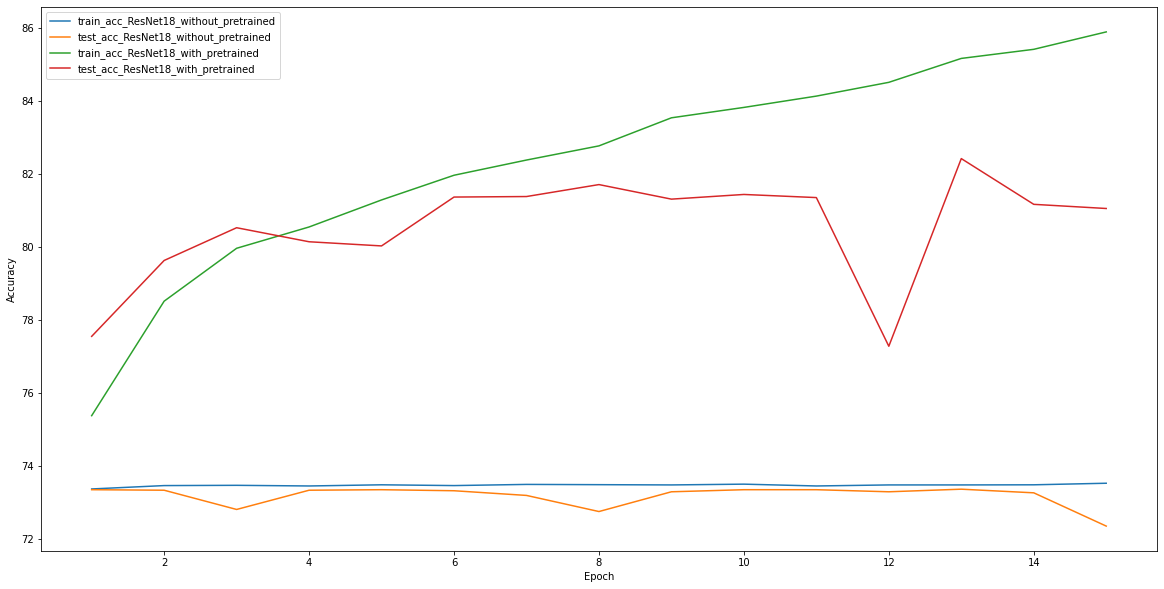

In [21]:
plot_acc_curves(df_18, "ResNet18")

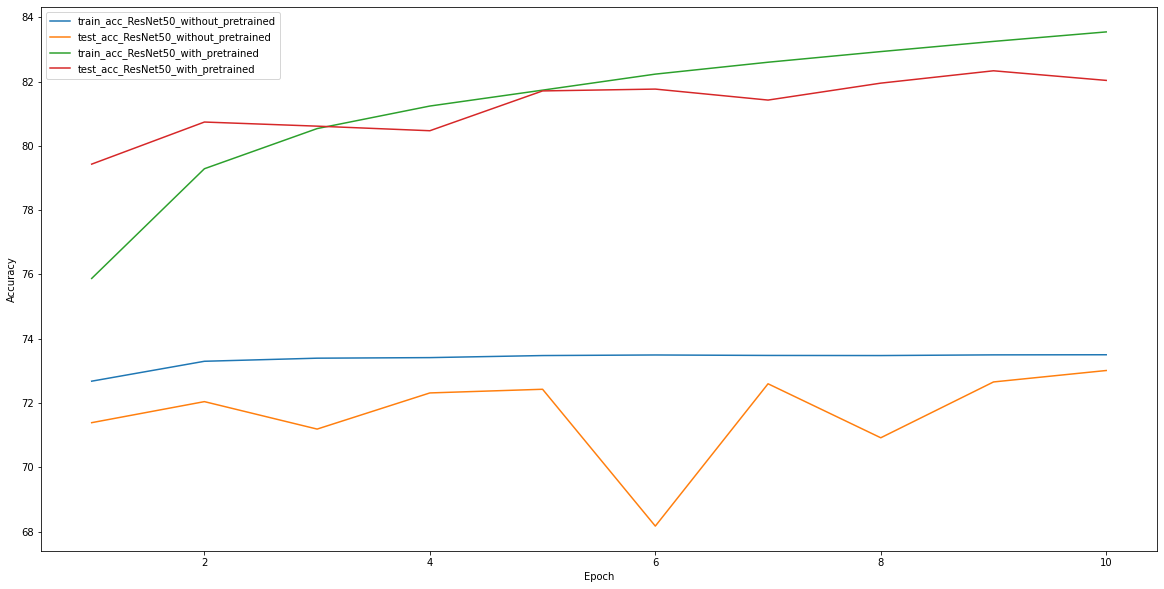

In [22]:
plot_acc_curves(df_50, "ResNet50")

In [23]:
for curve_name in df_18.columns[1: ]:
    print("The best {}ing accuracy of ResNet18 model {} pretrained weights is: {:.2f}%".format(curve_name.split("_")[0], curve_name.split("_")[-2], df_18[curve_name].max()))

The best training accuracy of ResNet18 model without pretrained weights is: 73.53%
The best testing accuracy of ResNet18 model without pretrained weights is: 73.37%
The best training accuracy of ResNet18 model with pretrained weights is: 85.89%
The best testing accuracy of ResNet18 model with pretrained weights is: 82.42%


In [24]:
for curve_name in df_50.columns[1: ]:
    print("The best {}ing accuracy of ResNet50 model {} pretrained weights is: {:.2f}%".format(curve_name.split("_")[0], curve_name.split("_")[-2], df_50[curve_name].max()))

The best training accuracy of ResNet50 model without pretrained weights is: 73.50%
The best testing accuracy of ResNet50 model without pretrained weights is: 73.01%
The best training accuracy of ResNet50 model with pretrained weights is: 83.54%
The best testing accuracy of ResNet50 model with pretrained weights is: 82.33%


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Use the 4 models with the best testing accuracy to plot confusion matrixes

In [39]:
def get_predictions(model, test_dataloader, device):
    model.eval()
    predictions = torch.tensor([], dtype = torch.float, device = device)
    ground_truths = torch.tensor([], dtype = torch.long, device = device)
    with torch.no_grad():
        for X_batched, y_batched in test_dataloader:
            X_batched = X_batched.to(device, dtype = torch.float)
            y_batched = y_batched.to(device, dtype = torch.long)
            ground_truths = torch.cat((ground_truths, y_batched))
            outputs = model(X_batched)
            predictions = torch.cat((predictions, outputs.max(dim = 1)[1]))   
    return predictions.detach().cpu().numpy(), ground_truths.detach().cpu().numpy()

In [27]:
all_models = [ResNet18(pretrained = False), ResNet18(pretrained = True), ResNet50(pretrained = False), ResNet50(pretrained = True)]
name = ["ResNet18_without_pretrained", "ResNet18_with_pretrained", "ResNet50_without_pretrained", "ResNet50_with_pretrained"]

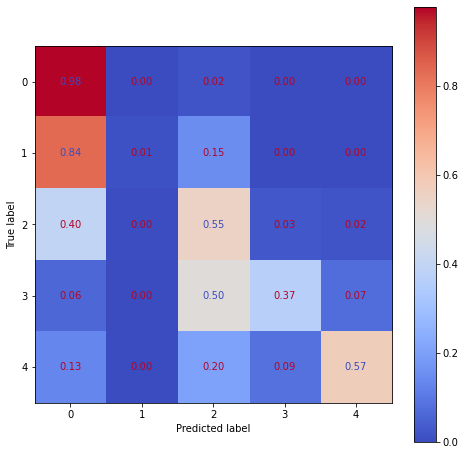

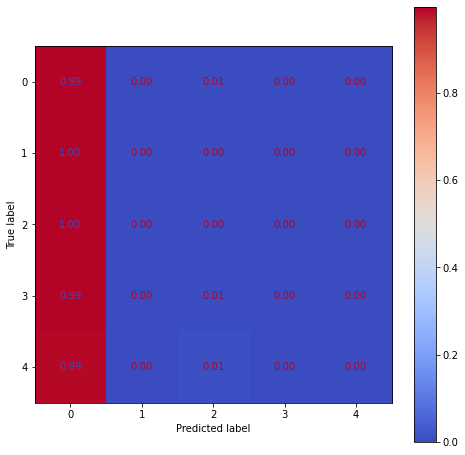

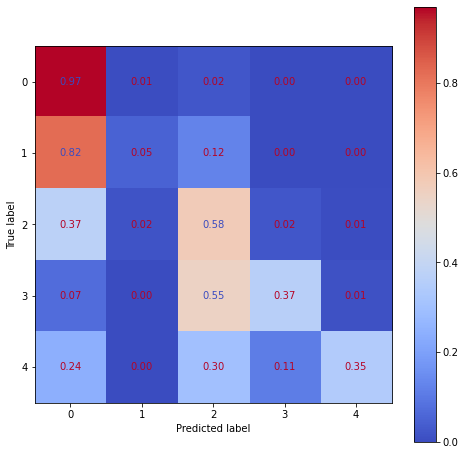

In [52]:
for i in range(4):
    model = all_models[i]
    model.load_state_dict(torch.load(os.path.join("D:/DL_lab3_params", name[i] + ".pt"), map_location = device))
    model.to(device)
    predictions, ground_truths = get_predictions(model, test_dataloader, device)
    cm = confusion_matrix(ground_truths, predictions, normalize = 'true')
    cm_plot = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize = (8, 8))
    cm_plot.plot(cmap = 'coolwarm', values_format = '.2f', ax = ax)
    plt.savefig(os.path.join("C:\\Users\\GL75\\OneDrive\\桌面\\深度學習\\Lab3", name[i] + ".png"))

# Unbalanced Dataset Analysis

In [53]:
train_dataset = RetinopathyDataset('D:/DL_lab3_data', 'train', mean, std)
test_dataset = RetinopathyDataset('D:/DL_lab3_data', 'test', mean, std)

> Found 28099 images...
> Found 7025 images...


In [63]:
labels, counts = np.unique(train_dataset.labels, return_counts = True)
proportions = np.round(counts / counts.sum() * 100, 2)
print(np.asarray((labels, counts)))
print(proportions, "unit = %")

[[    0     1     2     3     4]
 [20655  1955  4210   698   581]]
[73.51  6.96 14.98  2.48  2.07] unit = %


In [64]:
labels, counts = np.unique(test_dataset.labels, return_counts = True)
proportions = np.round(counts / counts.sum() * 100, 2)
print(np.asarray((labels, counts)))
print(proportions, "unit = %")

[[   0    1    2    3    4]
 [5153  488 1082  175  127]]
[73.35  6.95 15.4   2.49  1.81] unit = %


In [66]:
import torch.nn.functional as F

In [67]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight = None, gamma = 2, reduction = 'mean'):
        super(FocalLoss, self).__init__(weight, reduction = reduction)
        self.gamma = gamma
        self.reduction = reduction
        self.weight = weight # the weight to balance the classes.
    def forward(self, inputs, targets):
        CEloss = F.cross_entropy(inputs, targets, reduction = self.reduction, weight = self.weight)
        Pt = torch.exp(-CEloss)
        focal_loss = ((1 - Pt) ** self.gamma * CEloss).mean()
        return focal_loss

In [68]:
loss_fn = FocalLoss()

The highest acc model is ResNet18 with pretraining, so we use this

In [73]:
batch_size18 = 32
epochs18 = 15
epochs18_FE = 5 # feature extraction, train only the last FC layer
epochs18_FT = epochs18 - epochs18_FE # fine-tuning all layers
lr = 1e-3
momentum = 0.9 # common one
weight_decay = 5e-4 # half of lr

In [70]:
train_dataset = RetinopathyDataset('D:/DL_lab3_data', 'train', mean, std)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size18, shuffle = True)
test_dataset = RetinopathyDataset('D:/DL_lab3_data', 'test', mean, std)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size18, shuffle = False)

> Found 28099 images...
> Found 7025 images...


In [77]:
ResNet18_with_pretrained = ResNet18()
'''Feature Extraction Step'''
params_FC_layer = []
for param_name, param in ResNet18_with_pretrained.named_parameters():
    if param.requires_grad:
          params_FC_layer.append(param)
optimizer = optim.SGD(params_FC_layer, lr = lr, momentum = momentum, weight_decay = weight_decay)
train_acc1, test_acc1 = train(ResNet18_with_pretrained, train_dataloader, test_dataloader, loss_fn, optimizer, epochs18_FE, device, "ResNet18_with_pretrained_focal_loss")
'''Fine-tuning step'''
for param in ResNet18_with_pretrained.parameters():
    param.requires_grad = True
optimizer = optim.SGD(ResNet18_with_pretrained.parameters(), lr = lr, momentum = momentum, weight_decay = weight_decay)
train_acc2, test_acc2 = train(ResNet18_with_pretrained, train_dataloader, test_dataloader, loss_fn, optimizer, epochs18_FT, device, "ResNet18_with_pretrained_focal_loss")
'''concat'''
train_acc = np.append(train_acc1, train_acc2)
test_acc = np.append(test_acc1, test_acc2)

Epoch  1: loss = 0.0074, accuracy = 74.52%
Epoch  2: loss = 0.0052, accuracy = 77.87%
Epoch  3: loss = 0.0044, accuracy = 79.23%
Epoch  4: loss = 0.0041, accuracy = 80.19%
Epoch  5: loss = 0.0038, accuracy = 80.73%
Epoch  1: loss = 0.0035, accuracy = 81.31%
Epoch  2: loss = 0.0034, accuracy = 81.71%
Epoch  3: loss = 0.0032, accuracy = 81.99%
Epoch  4: loss = 0.0030, accuracy = 82.33%
Epoch  5: loss = 0.0028, accuracy = 82.68%
Epoch  6: loss = 0.0026, accuracy = 83.29%
Epoch  7: loss = 0.0026, accuracy = 83.44%
Epoch  8: loss = 0.0024, accuracy = 83.78%
Epoch  9: loss = 0.0022, accuracy = 84.36%
Epoch 10: loss = 0.0022, accuracy = 84.53%


In [78]:
print("The highest training accuracy is {:.2f}%".format(train_acc.max()))
print("The highest testing accuracy is {:.2f}%".format(test_acc.max()))

The highest training accuracy is 84.53%
The highest testing accuracy is 81.42%


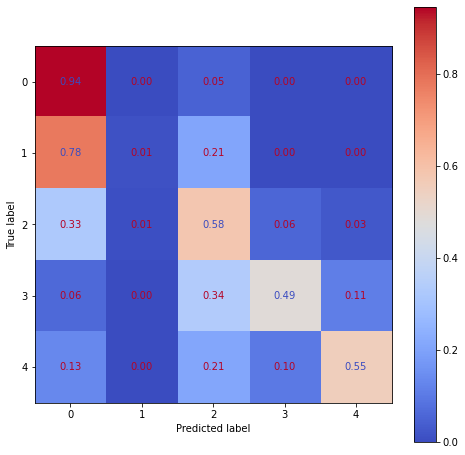

In [79]:
predictions, ground_truths = get_predictions(ResNet18_with_pretrained, test_dataloader, device)
cm = confusion_matrix(ground_truths, predictions, normalize = 'true')
cm_plot = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize = (8, 8))
cm_plot.plot(cmap = 'coolwarm', values_format = '.2f', ax = ax)
plt.savefig(os.path.join("C:\\Users\\GL75\\OneDrive\\桌面\\深度學習\\Lab3", "models_with_focal_loss.png"))